<a href="https://colab.research.google.com/github/mkhetan/ph2_session1/blob/master/SentimentUsingGlove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Prediction From Movie Reviews

* Use GloVe Word Embeddings

The code is extracted from the book - [Deep Learning with Python - Francois Chollet](http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf).

Refer to Chapter 6 - Deep leraning for text and sequences.


## Imports

In [0]:
import numpy as np
import os

## Download IMDB Raw Dataset

There is Imdb dataset as part of Keras dataset as well.
But, they are optimized and provide the reviews in terms of integers (word indices). There may be a way to obatin the real review (by fetching the real word from the word-index).

Instead the Raw Imdb dataset is provided by the Keras author at the below mentioned url location. Let's make use of that.

In [2]:
## keras provides the processed Imdb dataset as list of word-indexes.
## We need to get the raw Imdb dataset
!wget --no-check-certificate http://mng.bz/0tIo

--2020-01-24 10:12:00--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2020-01-24 10:12:00--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2020-01-24 10:12:00--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.206.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.206.245|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo’

0tIo                100%[===================>]  57.90M  74.2MB/s    in 0.8s    

2020-01-24 10:12:01 (74.2 MB/s) - ‘0tIo’ saved [60711700/6071170

In [0]:
!unzip -q 0tIo

In [4]:
!pwd

/content


## Check Dataset
Count number of positive and negative examples (12500 each)



In [5]:
!ls -1 aclImdb/train/neg | wc -l

12500


In [6]:
!ls -1 aclImdb/train/pos | wc -l

12500


## Read Imdb Dataset

Read the dataset by going over both postive and negative review directories under **train** folder of the dataset.

In [0]:
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

# go thru both directories
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)

    # go thru each review in the directory
    for fname in os.listdir(dir_name):
        nm, ext = os.path.splitext(fname)
        # get the extension
        if ext == '.txt':
        # get the review
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            # build the labels
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [8]:
print(len(labels))

25000


In [9]:
print(len(texts))

25000


In [10]:
print(texts[0])

I rented this horrible movie. The worst think I have ever seen. I believe a 1st grade class could have done a better job. The worse film I have ever seen and I have seen some bad ones. Nothing scary except I paid 1.50 to rent it and that was 1.49 too much. The acting is horrible, the characters are worse and the film is just a piece of trash. The slauther house scenes are so low budget that it makes a B movied look like an Oscar candidate. All I can say is if you wnat to waste a good evening and a little money go rent this horrible flick. I would rather watch killer clowns from outer space while sitting in a bucket of razors than sit through this flop again


In [11]:
print(labels[0])

0


## Tokenize the Imdb Reviews

For each review (group of words), convert them into word-indices (index to unique word).

In [12]:
%tensorflow_version 1.0
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


### Configurations

In [0]:
maxlen = 100 # cuts off reviews after 100 words

# let's try 1000 words
#maxlen = 1000
training_samples = 8000 # train only on 8000 samples
validation_samples = 10000
# Only the most common 10000 words will be kept by the tokenizer
max_words = 10000

### Tokenize the reviews

In [14]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


data is sequence of 100 words

In [15]:
print(data[0])

[ 123  107    2   10   25  107   46   75  659  161  626  546   10 1534
  297 1559    5  847    9    2   12   13  297   96   73    1  113    6
  524    1  102   23  430    2    1   19    6   40    3  415    4 1153
    1  310  136   23   35  361  349   12    9  163    3  500  165   37
   32  731 6108   29   10   67  132    6   44   22    5  434    3   49
 2186    2    3  114  275  137  847   11  524  506   10   59  244  103
  452   36 4138  831  134 1260    8    3 9092    4   71  866  140   11
 4043  171]


In [16]:
print(labels[0])

0


### Split data into training and validation set.

In [17]:
# Splits the data into a training set and a validation set, but first shuffles the data because you're starting with data in which samples are ordered, all negatives first, then all positives
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

print(len(x_train))
print(len(y_train))
print(y_train.shape)
print(len(x_val))
print(len(y_val))

8000
8000
(8000,)
10000
10000


## Download Glove Pre Trained Embeddings

* The GloVe (Global Vectors for Word Representation) is one form of word embeddings. It is built based on **word co-occurrence statistics**.

* The **word co-occurrence** means, whether the two words co-occur (next to each other) in the corpse.

* See wikipedia for more info.

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-24 10:43:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-24 10:43:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-24 10:43:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Read Pre Trained Glove Embeddings

In [0]:
glove_dir = '/content'

# use 400K words, 50 dimension pre trained glove embeddings
#embedding_dim = 50
#embedding_file_name = 'glove.6B.50d.txt'

# use 400K words, 100 dimension pre trained glove embeddings
embedding_dim = 300
embedding_file_name = 'glove.6B.300d.txt'

In [21]:
# build the dictionary to store word -> embedding info.
embeddings_index = {}

f = open(os.path.join(glove_dir, embedding_file_name ))

# read the embedding entries 
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [0]:
print(list(embeddings_index.keys())[0:20])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']


Showing 100 dimensions of word "the"

In [0]:
print(embeddings_index['the'])
print(len(embeddings_index['the']))

[ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-02  1

## Prepare Glove word-embeddings matrix

For each word from the word_index (from tokenizer), get the Glove Embeddings for that word and build the embedding matrix.
Note that we are considering only the limited number of words (max_words = 10000)

In [22]:
# build embedding matrix for the words in our reviews
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            #Words not found in the embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(10000, 300)


## Define Model

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3840128   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_

## Load the Glove Embeddings in the Model

In [24]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Train the model

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val)
                    )

model.save_weights('pre_trained_glove_model.h5')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/20
8000/8000 [==============================] - 9s 1ms/step - loss: 1.0509 - acc: 0.6596 - val_loss: 1.1401 - val_acc: 0.6523
Epoch 2/20
8000/8000 [==============================] - 9s 1ms/step - loss: 0.5288 - acc: 0.9474 - val_loss: 0.8803 - val_acc: 0.7268
Epoch 3/20
8000/8000 [==============================] - 9s 1ms/step - loss: 0.3444 - acc: 0.9890 - val_loss: 0.9155 - val_acc: 0.6960
Epoch 4/20
8000/8000 [==============================] - 9s 1ms/step - loss: 0.2481 - acc: 0.9988 - val_loss: 0.8041 - val_acc: 0.7191
Epoch 5/20
8000/8000 [==============================] - 9s 1ms/step - loss: 0.1887 - acc: 0.9991 - val_loss: 0.8042 - val_acc: 0.7133
Epoch 6/20
8000/8000 [==============================] - 9s 1ms/step - loss: 0.1676 - acc: 0.9961 - val_loss: 0.8878 - val_acc: 0.7081
Epoch 7/20
8000/8000 [===========================

## Plot the result

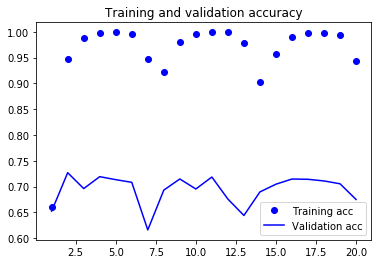

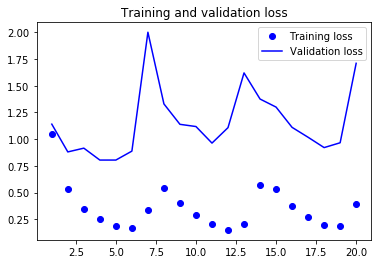

In [26]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluate Model Using Test Data

### Tokenize the test data

In [0]:
test_dir = os.path.join(imdb_dir, 'test')
labels_test = []
texts_test = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        nm, ext = os.path.splitext(fname)
        if ext == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts_test.append(f.read())
            f.close()

            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

In [0]:
sequences_test = tokenizer.texts_to_sequences(texts_test)
x_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.asarray(labels_test)

In [29]:
#model.load_weights('pre_trained_glove_model.h5')
score = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 9s 348us/step


In [30]:
print('The accuracy of test data is: ', score[1])

The accuracy of test data is:  0.67152
